In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
from fastai.vision import *
from fastai import * 
from fastai.text import *
from pathlib import Path 
from tqdm import tqdm
tqdm.pandas(desc="my bar!")

In [3]:
import torchtext
from torchtext.data import Iterator, BucketIterator
from torchvision import transforms, utils
import torchvision
from torchvision.models import *
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset
from torch import *
from torch import hub
from sklearn.metrics import confusion_matrix, f1_score, auc, roc_curve, precision_recall_curve

# Vision Model

In [4]:
bs = 200

In [5]:
path = os.getcwd(); path

'D:\\JupyterNotebooks\\KaggleWhale'

In [6]:
path_train = Path(path+"\\train")
path_test = Path(path+"\\test")

In [7]:
fnames_train = get_image_files(path_train)
fnames_test = get_image_files(path_test)

In [168]:
#fnames_train = fnames_train[:1280]

In [8]:
df = pd.read_csv(str(path+"/labels.csv"),header='infer')

In [170]:
len(fnames_train)


25361

In [154]:
valid_label = df.Id.drop_duplicates()

In [214]:
valid_label;

In [171]:
testing = list(df.Id)

In [201]:
turto = []
for j in fnames_train:
    turto.append(str(j))

In [251]:
turto;

In [308]:
validationSet = []
for i in df.Id.drop_duplicates().index.values.astype(int):
    validationSet.append(str(fnames_train[i])[38:])
#    testing.append(testing[i])

In [302]:
newdf = df.iloc[df.Id.drop_duplicates().index];
#vali_data = (ImageList.from_df(newdf,str(path+"\\train"))
#       )

In [9]:
train_transforms = transforms.Compose([
                                      transforms.Resize((100, 100)),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                             std=[0.229, 0.224, 0.225])
])

In [309]:
def isValidationImg(fileName):
    return fileName in validationSet

In [343]:
data = (ImageList.from_folder(path)      # the data is present in this folder
        .split_by_valid_func(isValidationImg)    # split using the set that contains all training images
       #.label_from_df(df,cols=2)
       #.transform(tfms,size=bs)
       #.databunch()
       #.normalize()
       )

In [10]:
#isValidationImg(df.Image[4])

In [12]:
#data_train = ImageDataBunch.from_df(str(path+"\\train"),df=df,label_col=1, ds_tfms=get_transforms(),valid_pct=0.1, size=224, bs=bs).normalize(imagenet_stats)

In [13]:
data_train = ImageDataBunch.from_lists(path,fnames_train,labels=df.Id, ds_tfms=get_transforms(),valid_pct=0.0, size=224, bs=bs).normalize(imagenet_stats)

In [176]:
#size=224,

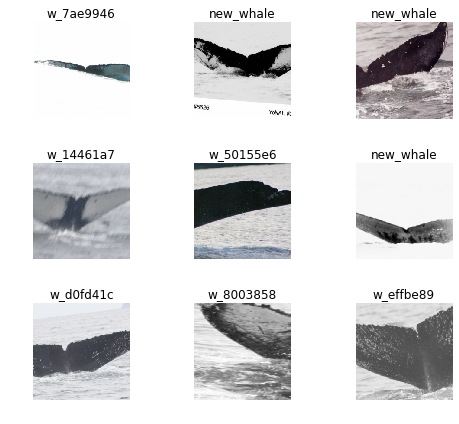

In [177]:
data_train.show_batch(rows=3, figsize=(7,6))

In [43]:
print(data_train.classes)

[' ', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '_', 'a', 'b', 'c', 'd', 'e', 'f', 'h', 'l', 'n', 'w']


In [42]:
len(data_train.classes),data_train.c

(22, 22)

In [14]:
#model = hub.load('pytorch/vision', 'resnet18', pretrained=True)
#model = models.resnet18(pretrained=True)

In [15]:
#models.resnet34

In [14]:
learn = cnn_learner(data_train,models.resnet34,pretrained=True,metrics=error_rate)

In [17]:
learn.model = learn.model.cuda()
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [15]:
from fastai.utils.mem import GPUMemTrace
with GPUMemTrace():
    learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,time


△Used Peaked MB:  6,257    157 (exit)


RuntimeError: CUDA out of memory. Tried to allocate 98.00 MiB (GPU 0; 8.00 GiB total capacity; 6.17 GiB already allocated; 91.52 MiB free; 3.20 MiB cached)

In [5]:
lm = True
clean = False

In [6]:
if lm: path = Path('../input'); 
list(path.iterdir())

[WindowsPath('../input/embeddings'),
 WindowsPath('../input/glove.840B.300d'),
 WindowsPath('../input/sample_submission.csv'),
 WindowsPath('../input/test.csv'),
 WindowsPath('../input/test_Clean.csv'),
 WindowsPath('../input/tmp_lm'),
 WindowsPath('../input/train.csv'),
 WindowsPath('../input/train_Clean.csv')]

train_df = pd.read_csv(path/'train.csv')
test_df = pd.read_csv(path/'test.csv')
allText_df = train_df.copy().append(test_df.copy(), sort=False)

In [7]:
if clean:
    train_df = pd.read_csv(path/'train.csv')
    test_df = pd.read_csv(path/'test.csv')
    
    train_df["question_text"] = train_df["question_text"].apply(lambda x: x.lower())
    test_df["question_text"] = test_df["question_text"].apply(lambda x: x.lower())
    #allText_df["question_text"] = allText_df["question_text"].apply(lambda x: x.lower())

    train_df['question_text'] = train_df['question_text'].apply(lambda x: clean_text(x))
    test_df['question_text'] = test_df['question_text'].apply(lambda x: clean_text(x))
    #allText_df["question_text"] = allText_df["question_text"].apply(lambda x: clean_text(x))

    train_df['question_text'] = train_df['question_text'].apply(lambda x: clean_numbers(x))
    test_df['question_text'] = test_df['question_text'].apply(lambda x:clean_numbers(x))
    #allText_df["question_text"] = allText_df["question_text"].apply(lambda x: clean_numbers(x))

    train_df['question_text'] = train_df['question_text'].apply(lambda x: replace_typical_misspell(x))
    test_df['question_text'] = test_df['question_text'].apply(lambda x: replace_typical_misspell(x))
    #allText_df["question_text"] = allText_df["question_text"].apply(lambda x: replace_typical_misspell(x))

    train_x = train_df['question_text'].fillna('_##_').values
    test_x = test_df['question_text'].fillna('_##_').values
    
    train_Full = pd.read_csv(path/'train.csv')
    test_Full = pd.read_csv(path/'test.csv')
    
    train_Full['question_text'] = train_x
    test_Full['question_text'] = test_x
    
    train_Full.to_csv('train_Clean.csv',index=False)
    test_Full.to_csv('test_Clean.csv',index=False)

import zipfile
zf = zipfile.ZipFile(path/'test.csv.zip')
df_test = pd.read_csv(zf.open('test.csv'))
zf = zipfile.ZipFile(path/'train.csv.zip')
df_train = pd.read_csv(zf.open('train.csv'))



In [8]:
#print(df_train.head(3))

print(train_df.shape)
print(test_df.shape)

In [9]:
# df_train.head(3)

In [10]:
def prepare_sequences():
    tokenizer = lambda text: text.split() # the function above is the function we will be using to tokenize the text
    TEXT = torchtext.data.Field(sequential=True, tokenize=tokenizer, lower=True)
    LABEL = torchtext.data.Field(sequential=False, use_vocab=False) # sequential and use_vocab=False since no text (binary)
    train_datafields = [("qid", None), ("question_text", TEXT), ("target", LABEL)]
    train = torchtext.data.TabularDataset( # If we had a validation set as well, we would add an additional .splits(...)
                        # path="data/train_cleaned_v2.csv", # the root directory where the data lies
                        path = path/'train_Clean.csv',
                        format='csv',
                        # if your csv header has a header, make sure to pass this to ensure it doesn't get proceesed as data!
                        skip_header=True, 
                        fields=train_datafields)
    test_datafields = [("qid", None),
                     ("question_text", TEXT)] 
    test = torchtext.data.TabularDataset( 
                path=path/'test_Clean.csv',
                format="csv",
                skip_header=True,
                fields=test_datafields)
    return TEXT, LABEL, train, test
# Chat Conversation End
# Type a message...



In [11]:
TEXT,LABEL,train,test = prepare_sequences()


LABEL.batch_first


In [12]:
TEXT.build_vocab(train, test, vectors = "glove.6B.50d")

In [13]:
train_storage = train

In [14]:
#train = train_storage

In [15]:
train,vali = train.split(0.8)

In [36]:
from torchtext.data import Iterator, BucketIterator
train_iter = BucketIterator(
    train, # we pass in the datasets we want the iterator to draw data from
    batch_size= 512, 
    sort_key= lambda x: len(x.question_text), # the BucketIterator needs to be told what function it should use to group the data.
    sort_within_batch=False, # sorting would add bias
    repeat=False)

vali_iter = BucketIterator(
    vali, # we pass in the datasets we want the iterator to draw data from
    batch_size= 512, 
    sort_key= lambda x: len(x.question_text), # the BucketIterator needs to be told what function it should use to group the data.
    sort_within_batch=False, # sorting would add bias
    repeat=True)

test_iter = Iterator(
    test,
    batch_size = 512,
    train=False,
    sort = False,
    sort_within_batch = False,
    repeat = False)

ngpu = 0
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

iter(test_iter).__next__().question_text

#len(train_iter)
#label_Size = next(iter(train_iter)).target
#len(label_Size[label_Size==1])
#train_iter.batches
#train_iter = iter(train_iter)
#train_iter.__next__().question_text
#train_iter.__next__().target
#iter(train_iter).__next__().question_text.shape

#smaller,_ = train.split(0.1)
TEXT.vocab.itos[10]

test_iter.dataset.examples.__getitem__(1).__dict__

#smaller.examples[0].question_text
test.examples.__getitem__(2).__dict__

In [17]:
#len(train)
#len(test_iter)

In [18]:
#train.examples[0].question_text

In [19]:
TEXT.vocab.vectors.shape

torch.Size([214945, 50])

TEXT.vocab.freqs

In [20]:
embed_size = 50
hidden_size = 300
ver1 = False
sigBCE = True
bidir = True
layer_LSTM = 2
layer_Lin = 3
dropout_LSTM = 0.1
dropout_Lin = 0.1

class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet,self).__init__()
        
        hidden_size = 64
        
        self.embedding = nn.Embedding(len(TEXT.vocab),embed_size)
        self.embedding.weight = nn.Parameter(TEXT.vocab.vectors)
        self.embedding_dropout = nn.Dropout2d(0.1)
        
        self.lstm = nn.LSTM(embed_size, hidden_size, bidirectional=True, batch_first=True)
        self.gru = nn.GRU(hidden_size*2, hidden_size, bidirectional=True, batch_first=True)
        
        self.linear = nn.Linear(hidden_size*4,2)
        self.relu = nn.ReLU()
        #self.dropout = nn.Dropout(0.1)
        self.out = nn.Linear(16,1)
        
    def forward(self,train):
        #print(train.shape)
        h_embedding = self.embedding(train)
        #print(h_embedding.shape)
        h_embedding = torch.squeeze(self.embedding_dropout(torch.unsqueeze(h_embedding,0)))
        #print(h_embedding.shape)
        
        h_lstm, _ = self.lstm(h_embedding)
        #print(h_lstm.shape)
        h_gru, _ = self.gru(h_lstm)
        #print(h_gru.shape)
        
        avg_pool = torch.mean(h_gru,1)
        #print(avg_pool.shape)
        #avg_pool = avg_pool.view(-1,64)
        max_pool, _ = torch.max(h_gru,1)
        #print(max_pool.shape)
        
        
        conc = torch.cat((avg_pool, max_pool),1)
        print(conc.shape)
        conc = self.relu(self.linear(conc))
        #print(conc.shape)
        #conc = self.dropout(conc)
        print(conc.shape)
        #out = nn.Sigmoid()(conc)
        
        out = nn.LogSoftmax(dim=1)(conc)
        
        #out = self.out(conc)
        #print(out[:,-1].shape)
        
        return out
    
    
    
    
batch = next(iter(train_iter)).question_text
net = NeuralNet()
#net(batch)

In [21]:
#batch = next(iter(train_iter)).question_text
#batch[30]
#layer_Lin

In [22]:
class LSTMTagger(nn.Module):
    def __init__(self):
        super(LSTMTagger, self).__init__()
                      
        self.hidden_dim = hidden_size
        
        self.embedding = nn.Embedding(len(TEXT.vocab),embed_size)
        self.embedding.weight = nn.Parameter(TEXT.vocab.vectors)
        
        
        #self.embedding_dropout = nn.Dropout2d(0.1)
        
        self.lstm_Layer = nn.LSTM(embed_size, hidden_size,num_layers = layer_LSTM, dropout = dropout_LSTM, bidirectional = bidir)
        
        self.lin_Layer = []
        
        self.lin_Layer_Dropout = dropout_Lin
        
        self.relu = nn.ReLU()
        
        if bidir:
            scale = 2
        else:
            scale = 1
        
        for _ in range(layer_Lin - 1):
            self.lin_Layer.append(nn.Linear(hidden_size*scale,hidden_size*scale))
            self.lin_Layer = nn.ModuleList(self.lin_Layer)
        if sigBCE:
            self.hidden2tag = nn.Linear(hidden_size*scale, 1)
        else:
            self.hidden2tag = nn.Linear(hidden_size*scale, 2)
    
    def forward(self, train):
        #print(train.shape)
        embeds = self.embedding(train)
        #print(embeds.shape)
        #print(embeds.view(len(train),64,-1).shape)
        #print(embeds.view(len(train),train.shape[1],-1).shape)
        lstm_out, _ = self.lstm_Layer(embeds)#embeds.view(len(train),train.shape[1],-1))
        #print(lstm_out.shape)
        
        if ver1:
            #print(lstm_out.shape)
            feature = lstm_out[-1,:,:] # -1 grabs last layer in list
            #print(feature.shape)
        
            for layer in self.lin_Layer:
                feature = layer(feature)
                feature = F.relu(feature)
                predict = self.hidden2tag(feature)
        
            feature = F.relu(feature)
            predict = self.hidden2tag(feature)
            if sigBCE:
                return nn.Sigmoid()(predict)
            else:
                return nn.LogSoftmax(dim=1)(predict)
        else:
           
            feature = torch.mean(lstm_out,0) #avg_pool
            #print(avg_pool.shape)
            for layer in self.lin_Layer:
                feature = layer(feature)
                feature = F.relu(feature)
                
            target_space = self.hidden2tag(feature)#.view(len(train),-1))
            #target_space = self.relu(target_space)
            
            #print(target_space.shape)
            if sigBCE:
                return nn.Sigmoid()(target_space)
            else:
                return F.log_softmax(target_space, dim=1)
            #print(target_score.shape)

inputs_check = next(iter(train_iter)).question_text

#print(inputs_check.shape)

model = LSTMTagger()

with torch.no_grad():
    inputs = inputs_check
    #print(len(inputs))
    score = model(inputs)
    print(score.shape)
    print(score)

torch.Size([128, 1])
tensor([[0.4897],
        [0.4895],
        [0.4895],
        [0.4896],
        [0.4896],
        [0.4895],
        [0.4895],
        [0.4897],
        [0.4895],
        [0.4895],
        [0.4895],
        [0.4896],
        [0.4896],
        [0.4895],
        [0.4896],
        [0.4896],
        [0.4896],
        [0.4895],
        [0.4895],
        [0.4895],
        [0.4896],
        [0.4894],
        [0.4895],
        [0.4895],
        [0.4896],
        [0.4896],
        [0.4895],
        [0.4897],
        [0.4897],
        [0.4895],
        [0.4896],
        [0.4895],
        [0.4895],
        [0.4895],
        [0.4897],
        [0.4896],
        [0.4895],
        [0.4894],
        [0.4895],
        [0.4898],
        [0.4895],
        [0.4897],
        [0.4895],
        [0.4895],
        [0.4895],
        [0.4895],
        [0.4897],
        [0.4895],
        [0.4895],
        [0.4896],
        [0.4895],
        [0.4896],
        [0.4894],
        [0.4894],
       

In [23]:
def weight_init(m):
    if  isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight.data)
        m.bias.data.zero_()

In [24]:
model = LSTMTagger()
model.apply(weight_init)
if sigBCE:
    loss_function = nn.BCELoss(reduction='none')
else:
    loss_function = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(),lr=0.2, momentum=0.9)

In [ ]:
validate = True

checking = next(iter(train_iter))
inputs_check = checking.question_text
target_check = checking.target


f1_train = []
auc_train = []
train_accu = []

avg_loss = 0

with torch.no_grad():
    inputs = inputs_check
    score1 = model(inputs)
    #print(score)
    
for epoch in range(2):
    model.train()
    avg_loss = 0
    training_set = iter(train_iter)
    vali_set = iter(vali_iter)
    model.zero_grad()
    all_preds = []
    all_actual = []
    for batch_num in range(len(train_iter)):
        model.train()
        sentence_data = next(training_set)
        vali_data = next(vali_set)
        sentence_in = sentence_data.question_text
        vali_in = vali_data.question_text
        
        
        #target -> target.unsqueeze(1)
        if sigBCE:
            targets = sentence_data.target.float()#.unsqueeze(1)
            vali_target = vali_data.target.float()
        else:
            targets = torch.LongTensor(sentence_data.target)#.unsqueeze(1)
            vali_target = torch.LongTensor(vali.target)
        optimizer.zero_grad()
        
        target_scores = model(sentence_in)
        
        loss = loss_function(target_scores.squeeze(1), targets)#.squeeze(1))#.reshape(64,1).squeeze(1))
        loss = (loss * (targets*17+1)/(targets*17+1).sum()).sum()#.mean()
        loss.backward()
        optimizer.step()
        
        
        model.eval()
        vali_scores = model(vali_in)
        vali_loss = loss_function(vali_scores.squeeze(1), vali_target).mean()
        vali_f1 = (np.asarray(vali_scores.squeeze(1)) > 0.5).astype(int)
        if sigBCE:
            #prediction = np.asarray(target_scores.squeeze(1)>0.5,dtype=float)
            #accuracy = np.asarray(prediction == np.asarray(targets)).sum()/len(targets)*100
            prediction = np.asarray(vali_scores.squeeze(1)>0.5,dtype=float)
            accuracy = np.asarray(prediction == np.asarray(vali_target)).sum()/len(vali_target)*100
        else:
            #prediction = target_scores.data.max(1)[1]
            #accuracy = np.asarray(prediction==targets).sum()/len(targets)*100
            prediction = vali_scores.data.max(1)[1]
            accuracy = np.asarray(prediction == vali_target).sum()/len(vali_target)*100
        #train_accu.append(accuracy)
        
        if sigBCE:
            all_preds.extend(target_scores.tolist())#torch.round(target_scores).tolist())
        else:
            all_preds.extend(torch.exp(target_scores).tolist())#torch.round(target_scores).tolist())
        all_actual.extend(targets.tolist())
        
        #print(np.asarray(target_scores)[:,1].max())
        
        #targets -> targets.reshape(64,1).squeeze(1)
        
        avg_loss += loss.item()
        
        #print(loss)
        if sigBCE:
            print(batch_num+1," of: ",len(train_iter), " Loss: ",loss.item()," F1 Val: ",f1_score(vali_f1, vali_target)," Val Acc: ",accuracy, " High: ", np.asarray(target_scores).max()," Low: ", np.asarray(target_scores).min())
        else:
            print(batch_num+1," of: ",len(train_iter), " Loss: ",loss.item()," Val Loss: ",vali_loss.item()," Acc: ",accuracy, " High: ", np.asarray(torch.exp(target_scores))[:,1].max()," Low: ", np.asarray(target_scores).min())
        
        
    
    #model.eval()
    avg_loss = avg_loss/len(train_iter)
    
    #if validate:
        #avg_val
    
    
    #else:
    print("Training loss for epoch {} is {}".format(epoch + 1, avg_loss))
    
    
    #train_confusion_matrix = confusion_matrix(all_actual, all_preds).ravel()
    if sigBCE:
        pred_Clas = (np.asarray(all_preds) > 0.5).astype(int)#-2.65).astype(int)#
    else:
        pred_Clas = (np.asarray(all_preds)[:,1] > np.asarray(all_preds)[:,0]).astype(int)#-2.65).astype(int)#
    train_confusion_matrix = confusion_matrix(all_actual, pred_Clas).ravel()
    
    print("Confusion matrix for epoch {}, tn={}, fp={}, fn={}, tp={}".format(epoch + 1, *train_confusion_matrix))
    f1_train.append(f1_score(all_actual, pred_Clas))
    print("F1 score for epoch {} is {}".format(epoch + 1, f1_train[-1]))
    fpr, tpr, _ = roc_curve(all_actual, pred_Clas, pos_label=1)
    auc_train.append(auc(fpr, tpr))
    print("AUC for epoch {} is {}\n".format(epoch + 1, auc_train[-1]))

with torch.no_grad():
    inputs = inputs_check
    score2 = model(inputs)
    #print(score)
        
        

1  of:  2041  Loss:  0.3863082528114319  F1 Val:  0.3414634146341463  Val Acc:  73.6328125  High:  0.9941413  Low:  0.108024865
2  of:  2041  Loss:  0.36439114809036255  F1 Val:  0.3711340206185567  Val Acc:  76.171875  High:  0.9981318  Low:  0.11055037
3  of:  2041  Loss:  0.30511441826820374  F1 Val:  0.31521739130434784  Val Acc:  75.390625  High:  0.9967886  Low:  0.111272566
4  of:  2041  Loss:  0.38811060786247253  F1 Val:  0.5131578947368421  Val Acc:  85.546875  High:  0.99779403  Low:  0.109010965
5  of:  2041  Loss:  0.33682185411453247  F1 Val:  0.43661971830985913  Val Acc:  84.375  High:  0.9960418  Low:  0.106019445
6  of:  2041  Loss:  0.30062249302864075  F1 Val:  0.48437499999999994  Val Acc:  87.109375  High:  0.994361  Low:  0.10217618
7  of:  2041  Loss:  0.27009639143943787  F1 Val:  0.5038167938931297  Val Acc:  87.3046875  High:  0.9722261  Low:  0.09857278
8  of:  2041  Loss:  0.305858314037323  F1 Val:  0.5441176470588235  Val Acc:  87.890625  High:  0.9767293

128  of:  2041  Loss:  0.3638386130332947  F1 Val:  0.45255474452554745  Val Acc:  85.3515625  High:  0.96988714  Low:  0.033851333
129  of:  2041  Loss:  0.2757585644721985  F1 Val:  0.3125  Val Acc:  78.515625  High:  0.9981554  Low:  0.03458413
130  of:  2041  Loss:  0.2763586938381195  F1 Val:  0.3673469387755102  Val Acc:  81.8359375  High:  0.99925977  Low:  0.03502542
131  of:  2041  Loss:  0.3081551492214203  F1 Val:  0.37499999999999994  Val Acc:  78.515625  High:  0.9996817  Low:  0.035404094
132  of:  2041  Loss:  0.31932532787323  F1 Val:  0.3404255319148936  Val Acc:  81.8359375  High:  0.99999404  Low:  0.03499032
133  of:  2041  Loss:  0.25063592195510864  F1 Val:  0.3636363636363637  Val Acc:  80.859375  High:  0.99981815  Low:  0.034727573
134  of:  2041  Loss:  0.26005324721336365  F1 Val:  0.481203007518797  Val Acc:  86.5234375  High:  0.9997125  Low:  0.03354145
135  of:  2041  Loss:  0.32307547330856323  F1 Val:  0.5294117647058824  Val Acc:  90.625  High:  0.9990

254  of:  2041  Loss:  0.3517393171787262  F1 Val:  0.4556962025316456  Val Acc:  83.203125  High:  0.9836205  Low:  0.03776669
255  of:  2041  Loss:  0.23865896463394165  F1 Val:  0.41726618705035967  Val Acc:  84.1796875  High:  0.9978004  Low:  0.0385428
256  of:  2041  Loss:  0.33204787969589233  F1 Val:  0.3529411764705882  Val Acc:  82.8125  High:  0.99614185  Low:  0.039336205
257  of:  2041  Loss:  0.27886852622032166  F1 Val:  0.4786324786324786  Val Acc:  88.0859375  High:  0.99728024  Low:  0.0384566
258  of:  2041  Loss:  0.2919992506504059  F1 Val:  0.5196850393700788  Val Acc:  88.0859375  High:  0.9879097  Low:  0.038003884
259  of:  2041  Loss:  0.3512512445449829  F1 Val:  0.49462365591397844  Val Acc:  90.8203125  High:  0.99016505  Low:  0.03638242
260  of:  2041  Loss:  0.34557169675827026  F1 Val:  0.5333333333333333  Val Acc:  89.0625  High:  0.9866599  Low:  0.035824243
261  of:  2041  Loss:  0.24483203887939453  F1 Val:  0.592  Val Acc:  90.0390625  High:  0.994

380  of:  2041  Loss:  0.29124152660369873  F1 Val:  0.5254237288135593  Val Acc:  89.0625  High:  0.9918401  Low:  0.031724155
381  of:  2041  Loss:  0.3394356071949005  F1 Val:  0.4347826086956521  Val Acc:  87.3046875  High:  0.9955923  Low:  0.03406032
382  of:  2041  Loss:  0.2500744163990021  F1 Val:  0.4460431654676259  Val Acc:  84.9609375  High:  0.99595755  Low:  0.035304237
383  of:  2041  Loss:  0.2876819968223572  F1 Val:  0.32727272727272727  Val Acc:  85.546875  High:  0.99686265  Low:  0.03302263
384  of:  2041  Loss:  0.25535422563552856  F1 Val:  0.4722222222222222  Val Acc:  85.15625  High:  0.9960651  Low:  0.033588383
385  of:  2041  Loss:  0.25722214579582214  F1 Val:  0.40559440559440557  Val Acc:  83.3984375  High:  0.99686605  Low:  0.031111846
386  of:  2041  Loss:  0.3851289749145508  F1 Val:  0.46511627906976744  Val Acc:  86.5234375  High:  0.9995086  Low:  0.030001039
387  of:  2041  Loss:  0.27609163522720337  F1 Val:  0.34862385321100914  Val Acc:  86.13

506  of:  2041  Loss:  0.277383416891098  F1 Val:  0.4303797468354431  Val Acc:  82.421875  High:  0.9837219  Low:  0.03560619
507  of:  2041  Loss:  0.27302584052085876  F1 Val:  0.379746835443038  Val Acc:  80.859375  High:  0.98247874  Low:  0.036295068
508  of:  2041  Loss:  0.3419232666492462  F1 Val:  0.44594594594594594  Val Acc:  83.984375  High:  0.9926454  Low:  0.035161197
509  of:  2041  Loss:  0.29853329062461853  F1 Val:  0.5384615384615385  Val Acc:  90.625  High:  0.97704893  Low:  0.03642675
510  of:  2041  Loss:  0.2675916850566864  F1 Val:  0.4885496183206107  Val Acc:  86.9140625  High:  0.9993973  Low:  0.032086473
511  of:  2041  Loss:  0.31143686175346375  F1 Val:  0.45217391304347815  Val Acc:  87.6953125  High:  0.99578804  Low:  0.030288251
512  of:  2041  Loss:  0.3718279004096985  F1 Val:  0.44680851063829785  Val Acc:  89.84375  High:  0.997235  Low:  0.027052034
513  of:  2041  Loss:  0.3984447419643402  F1 Val:  0.43243243243243235  Val Acc:  87.6953125  

632  of:  2041  Loss:  0.24514976143836975  F1 Val:  0.3859649122807018  Val Acc:  86.328125  High:  0.98893356  Low:  0.011143967
633  of:  2041  Loss:  0.2839166522026062  F1 Val:  0.4222222222222222  Val Acc:  89.84375  High:  0.9936301  Low:  0.009255832
634  of:  2041  Loss:  0.3035130500793457  F1 Val:  0.5063291139240507  Val Acc:  84.765625  High:  0.9874685  Low:  0.01223894
635  of:  2041  Loss:  0.252081960439682  F1 Val:  0.4210526315789473  Val Acc:  84.9609375  High:  0.9943869  Low:  0.01091605
636  of:  2041  Loss:  0.25410255789756775  F1 Val:  0.4049079754601227  Val Acc:  81.0546875  High:  0.9974565  Low:  0.01238158
637  of:  2041  Loss:  0.32718706130981445  F1 Val:  0.48044692737430167  Val Acc:  81.8359375  High:  0.99761957  Low:  0.013400337
638  of:  2041  Loss:  0.25122833251953125  F1 Val:  0.4117647058823529  Val Acc:  84.375  High:  0.9976701  Low:  0.0131759485
639  of:  2041  Loss:  0.3447471857070923  F1 Val:  0.5058823529411766  Val Acc:  83.59375  Hi

758  of:  2041  Loss:  0.29799678921699524  F1 Val:  0.29591836734693877  Val Acc:  73.046875  High:  0.9985752  Low:  0.019299565
759  of:  2041  Loss:  0.36406898498535156  F1 Val:  0.21978021978021978  Val Acc:  72.265625  High:  0.9973526  Low:  0.026456181
760  of:  2041  Loss:  0.39694613218307495  F1 Val:  0.37037037037037035  Val Acc:  76.7578125  High:  0.999838  Low:  0.022391815
761  of:  2041  Loss:  0.35979193449020386  F1 Val:  0.4635761589403974  Val Acc:  84.1796875  High:  0.99553865  Low:  0.021253314
762  of:  2041  Loss:  0.29123663902282715  F1 Val:  0.31746031746031744  Val Acc:  83.203125  High:  0.99348116  Low:  0.021132367
763  of:  2041  Loss:  0.33435046672821045  F1 Val:  0.5454545454545454  Val Acc:  91.2109375  High:  0.9822504  Low:  0.01885235
764  of:  2041  Loss:  0.239305779337883  F1 Val:  0.46315789473684216  Val Acc:  90.0390625  High:  0.9742556  Low:  0.019767074
765  of:  2041  Loss:  0.3909864127635956  F1 Val:  0.5625  Val Acc:  94.53125  Hig

884  of:  2041  Loss:  0.2759150266647339  F1 Val:  0.40268456375838924  Val Acc:  82.6171875  High:  0.99516076  Low:  0.017250778
885  of:  2041  Loss:  0.24533486366271973  F1 Val:  0.3361344537815126  Val Acc:  84.5703125  High:  0.9979462  Low:  0.019994311
886  of:  2041  Loss:  0.2512144446372986  F1 Val:  0.5289256198347108  Val Acc:  88.8671875  High:  0.9978555  Low:  0.021612266
887  of:  2041  Loss:  0.3241859972476959  F1 Val:  0.4897959183673469  Val Acc:  90.234375  High:  0.99757725  Low:  0.02178043
888  of:  2041  Loss:  0.36522623896598816  F1 Val:  0.3404255319148936  Val Acc:  87.890625  High:  0.9966988  Low:  0.020053621
889  of:  2041  Loss:  0.3842605650424957  F1 Val:  0.5354330708661418  Val Acc:  88.4765625  High:  0.995533  Low:  0.020861996
890  of:  2041  Loss:  0.34258967638015747  F1 Val:  0.6027397260273972  Val Acc:  94.3359375  High:  0.9945966  Low:  0.023570353
891  of:  2041  Loss:  0.20264951884746552  F1 Val:  0.5483870967741935  Val Acc:  89.06

In [ ]:
vali_data

In [ ]:
torch.save(model,"C:/Users/xw5735/PWinFolder/WPy-3661/notebooks/KaggleChal/LSTMTaggerFull23.pt")

model = torch.load("C:/Users/xw5735/PWinFolder/WPy-3661/notebooks/KaggleChal/LSTMTaggerFull.pt")

In [ ]:
batch_size = 10
nb_classes = 2
target = torch.LongTensor(batch_size).random_(nb_classes)
#print((targets*5+1))
print((loss * (targets*5+1)).mean())

In [ ]:
prediction = np.asarray(target_scores.squeeze(1)>0.5,dtype=float)
target_scores

In [ ]:
#preddd = np.asarray(all_preds)[:,1]
#preddd_clas = (preddd>-0.45).astype(int)
#train_confusion_matrix = confusion_matrix(all_actual, preddd_clas).ravel()
#print("Confusion matrix for epoch {}, tn={}, fp={}, fn={}, tp={}".format(epoch + 1, *train_confusion_matrix))
#pred_Clas = (np.asarray(all_preds)[:,1] > np.asarray(all_preds)[:,0]).astype(int)
#f1_score(all_actual, pred_Clas)
#pred_Clas

In [ ]:
#preddd = (np.asarray(all_preds)[:,1] > np.asarray(all_preds)[:,0]).astype(int)
#len(preddd[preddd>0])

In [ ]:
def threshold_search(y_true, y_proba, plot=False):
    precision, recall, thresholds = precision_recall_curve(y_true, y_proba)
    thresholds = np.append(thresholds, 1.001) 
    F = 2 / (1/precision + 1/recall)
    best_score = np.max(F)
    best_th = thresholds[np.argmax(F)]
    if plot:
        plt.plot(thresholds, F, '-b')
        plt.plot([best_th], [best_score], '*r')
        plt.show()
    search_result = {'threshold': best_th , 'f1': best_score}
    return search_result

In [ ]:
def threshold_search_2(y_true, y_proba):
    best_threshold = 0
    best_score = 0
    for threshold in tqdm([i * 0.01 for i in range(100)], disable=True):
        score = f1_score(y_true=y_true, y_pred=y_proba > threshold)
        if score > best_score:
            best_threshold = threshold
            best_score = score
    search_result = {'threshold': best_threshold, 'f1': best_score}
    return search_result

In [ ]:
#threshold_search_2(all_actual, preddd)
#np.asarray(all_preds)[:,1].max()

In [ ]:
#preddd = np.asarray(all_preds)[:,1]
#preddd_clas = (preddd>-0.45).astype(int)
#preddd.max()
#len(preddd_clas[preddd_clas == 1])

In [ ]:
#thr = threshold_search_2(all_actual, np.asarray(all_preds));thr

In [ ]:
#thr = threshold_search(all_actual, np.asarray(all_preds), plot=True);thr

In [ ]:
all_final_preds = []
all_final_rounding = []
model.eval()
testing_batches = iter(test_iter)
for batch_num in range(len(test_iter)):
    final_preds = model(next(testing_batches).question_text)
    prediction = np.asarray(final_preds>0.5,dtype=float)
    print(batch_num+1,"out of: ",len(test_iter)," max: ",np.asarray(final_preds).max())
    all_final_preds.extend(final_preds.tolist())
    all_final_rounding.extend(prediction.tolist())
    

#probab = np.asarray(final_preds)[:,1]

#final_preds_clas = (probab>thr['threshold']).astype(int)

#final_preds_clas.shape

In [ ]:
sub = pd.read_csv(path/'sample_submission.csv')
sub['prediction'] = (np.asarray(all_final_preds)>0.5).astype(int)
sub.to_csv("submission_Kag_Full5.csv",index=False)

# Submission Encoding/Decoding

In [ ]:
import os
#os.chdir(os.getcwd()+'/KaggleChal')
path2 = os.getcwd()

sub = pd.read_csv(path2+'/submission_Kag_Full3.csv')
pred_str = ''.join(str(x) for x in list(sub.prediction.values))
print(len(pred_str))

sbase = "".join(chr(i) for i in range(0,65535) if chr(i).isalnum())

def encode(bin_str, sbase):
    n = int(bin_str,2)   
    code = []
    base = len(sbase)
    while n > 0:
        n, c = divmod(n, base)
        code.append(sbase[c])
    code = reversed(code)
    return ''.join(code)

def decode(code, sbase, size):
    code = reversed(code)
    base = len(sbase)
    bin_str =  bin(sum([sbase.index(c)*base**i for i, c in enumerate(code)]))[2:]
    bin_str = (size-len(bin_str))*'0' + bin_str
    return bin_str
# Compression using conversion to hexadecimal base
nhex = hex(int(pred_str,2))
assert int(pred_str,2) == int(nhex,16)
len(nhex)

# Compression using a big base
pred_compress = encode(pred_str, sbase)
len(pred_compress)

print(pred_compress)

In [ ]:
np.asarray(all_final_preds).max()

In [ ]:
testing_batches = iter(test_iter)

In [ ]:
for i, weop in enumerate(test_iter):
    print(i," ",weop.question_text)

In [ ]:
enumerate(test_iter)

In [ ]:
itering = next(testing_batches)

In [ ]:
itering.input_fields

In [ ]:
itering.question_text.shape

In [ ]:
TEXT.vocab.itos[3]

In [ ]:
#thr['threshold']

def train_model(model, train_data, epochs, show=False):
    
    #optimizer = torch.optim.Adam(model.parameters())
    optimizer = optim.SGD(model.parameters(), lr=0.0001)
    #loss_function = nn.BCEWithLogitsLoss(reduction='mean')
    loss_function = nn.NLLLoss()
    
    print("The loss function being used is {}".format(loss_function))
    errors = []
    eval_errors = []
    f1_train = []
    auc_train = []
    f1_eval = []
    auc_eval = []
    
    num_training_batches = len(train_data)
    
    for epoch in range(epochs):
        print("Epoch {}".format(epoch + 1))
        print("Training mode")
        model.train()
        train_iter = iter(train_data)
        model.zero_grad()
        train_loss = 0
        all_preds = []
        all_actual = []
        for batch_num in range(num_training_batches):
            print("Batch {}".format(batch_num + 1))
            print("Out of {}".format(num_training_batches))
            batch = next(train_iter)
            text, class_vector = batch.question_text.transpose(0,1),batch.target.unsqueeze(1)
            #print(batch)
            #print(text.shape)
            #optimizer.zero_grad()
            text_pred = model(text)
            #print(text_pred)
            print(class_vector.shape)
            print(torch.max(class_vector,1)[0].shape)
            loss = loss_function(text_pred,class_vector.reshape(64,1).squeeze(1)) #torch.max(class_vector,1)[0])
            print(loss)
            print(text_pred.squeeze(1))
            print(torch.max(class_vector,1)[0])
            loss.backward()
            optimizer.step()
    

    
    

In [ ]:
#train_iters = iter(train_iter)

In [ ]:
#wee = next(train_iters)

In [ ]:
#wee.question_text.shape